This notebook covers data extraction for the dataset used to train the CELFANN model in the research paper "A hybrid stock trading framework integrating technical analysis with machine learning" (Dash & Dash, 2016)

In [26]:
# Import necessary libraries
# To install, run "conda install -c conda-forge <package1> <package2>" in the Anaconda prompt
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
plt.style.use('seaborn-v0_8-darkgrid')

In [27]:
# Set data parameters
start_date = '2020-01-06' #First Monday of this decade
end_date = '2025-03-15' #Last Friday  
tickers = {
    'NVIDIA': 'NVDA',
    'Taiwan Semiconductors': 'TSM',
    'Invesco QQQ': 'QQQ'
}

In [28]:
# Downloading data
data = {}
for name, ticker in tickers.items():
    print(f"Downloading data for {name} ({ticker})...")
    data[name] = yf.download(ticker, start=start_date, end=end_date)
    print(f"Downloaded {len(data[name])} days of data for {name}.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded 1305 days of data for NVIDIA.
Downloaded 1305 days of data for Taiwan Semiconductors.
Downloaded 1305 days of data for Invesco QQQ.


In [29]:
# Extract closing prices for correlation analysis
close_prices = pd.DataFrame()
for name, ticker_data in data.items():
    close_prices[name] = ticker_data['Close']

print(close_prices)
print(type(close_prices))

                NVIDIA  Taiwan Semiconductors  Invesco QQQ
Date                                                      
2020-01-06    5.901214              51.896442   209.056198
2020-01-07    5.972661              52.737434   209.027023
2020-01-08    5.983861              53.126266   210.598160
2020-01-09    6.049580              53.560318   212.382675
2020-01-10    6.081940              53.225742   211.839523
...                ...                    ...          ...
2025-03-10  106.970161             169.987686   472.730011
2025-03-11  108.750000             170.306458   471.600006
2025-03-12  115.739998             176.482391   476.920013
2025-03-13  115.580002             170.924042   468.339996
2025-03-14  121.669998             173.414337   479.660004

[1305 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>



Price Correlation Matrix:
                         NVIDIA  Taiwan Semiconductors  Invesco QQQ
NVIDIA                 1.000000               0.900729     0.911726
Taiwan Semiconductors  0.900729               1.000000     0.941220
Invesco QQQ            0.911726               0.941220     1.000000


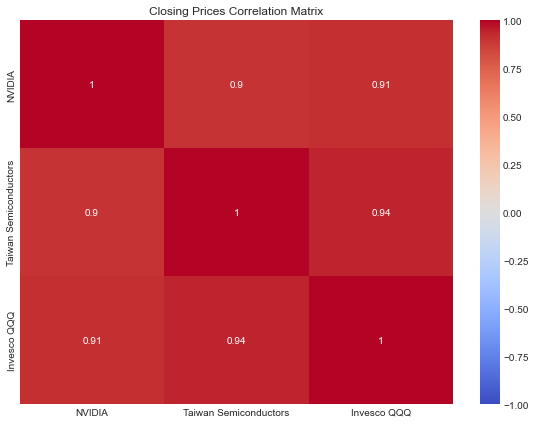

In [30]:
# Calculate correlation matrix
correlation = close_prices.corr()
print("\nPrice Correlation Matrix:")
print(correlation)

# Visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Closing Prices Correlation Matrix')
plt.tight_layout()
plt.show()

In [31]:
for name, ticker_data in data.items():
    print (data[name])

Price            Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                 
2020-01-06    5.901214    5.906442    5.757082    5.783220  262636000
2020-01-07    5.972661    6.018464    5.884538    5.929595  314856000
2020-01-08    5.983861    6.025184    5.928349    5.968428  277108000
2020-01-09    6.049580    6.122020    5.995811    6.070242  255112000
2020-01-10    6.081940    6.187239    6.067751    6.156869  316296000
...                ...         ...         ...         ...        ...
2025-03-10  106.970161  111.839709  105.450297  109.889891  366487400
2025-03-11  108.750000  112.229676  104.760361  106.980159  354865700
2025-03-12  115.739998  116.760002  112.879997  114.120003  323857500
2025-03-13  115.580002  117.760002  113.790001  117.029999  299033100
2025-03-14  121.669998  121.879997  118.150002  118.610001  277593500

[1305 rows x 5 colu

In [32]:
# Function calculates six technical indicators used by the CEFLANN model
def calculate_technical_indicators(df):

    data = df.copy()

    # Extract series from dataframe
    close_series = data['Close'].squeeze()
    low_series = data['Low'].squeeze()
    high_series = data['High'].squeeze()
    
    # 1: Simple Moving Average (MA15)
    data['MA15'] = close_series.rolling(window=15).mean()
    
    # 2: MACD (12, 26)
    data['EMA12'] = close_series.ewm(span=12, adjust=False).mean()
    data['EMA26'] = close_series.ewm(span=26, adjust=False).mean()
    data['MACD26'] = data['EMA12'] - data['EMA26']
    
    # 3: Stochastic Oscillator K14
    n = 14
    min_low = low_series.rolling(window=n).min()
    max_high = high_series.rolling(window=n).max()
    data['L14'] = min_low
    data['H14'] = max_high
    data['K14'] = 100 * ((close_series - min_low) / (max_high - min_low))
    
    # 4: Stochastic Oscillator D3
    data['D3'] = data['K14'].rolling(window=3).mean()
    
    # 5: Relative Strength Index (14)
    delta = close_series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI14'] = 100 - (100 / (1 + rs))
    
    # 6: Larry Williams R% (WR14)
    data['WR14'] = -100 * ((max_high - close_series) / (max_high - min_low))
    
    # Clean up columns
    data = data.drop(['L14', 'H14', 'EMA12', 'EMA26'], axis=1)
    
    # Columns added: MA15, MACD26, K14, D3, RSI14, WR14
    return data

In [33]:
# Calculate technical indicators for all tickers
tech_data = data.copy()
for name in tickers.keys():
    tech_data[name] = calculate_technical_indicators(tech_data[name])

print(tech_data['NVIDIA'].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2020-01-06 to 2025-03-14
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, NVDA)   1305 non-null   float64
 1   (High, NVDA)    1305 non-null   float64
 2   (Low, NVDA)     1305 non-null   float64
 3   (Open, NVDA)    1305 non-null   float64
 4   (Volume, NVDA)  1305 non-null   int64  
 5   (MA15, )        1291 non-null   float64
 6   (MACD26, )      1305 non-null   float64
 7   (K14, )         1292 non-null   float64
 8   (D3, )          1290 non-null   float64
 9   (RSI14, )       1292 non-null   float64
 10  (WR14, )        1292 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 122.3 KB
None


In [34]:
selected_data = {ticker: df[['MA15', 'MACD26', 'K14', 'D3', 'RSI14', 'WR14']] 
                 for ticker, df in tech_data.items()}
print(selected_data)

{'NVIDIA': Price             MA15    MACD26        K14         D3      RSI14       WR14
Ticker                                                                      
Date                                                                        
2020-01-06         NaN  0.000000        NaN        NaN        NaN        NaN
2020-01-07         NaN  0.005699        NaN        NaN        NaN        NaN
2020-01-08         NaN  0.010993        NaN        NaN        NaN        NaN
2020-01-09         NaN  0.020258        NaN        NaN        NaN        NaN
2020-01-10         NaN  0.029868        NaN        NaN        NaN        NaN
...                ...       ...        ...        ...        ...        ...
2025-03-10  124.256572 -5.779603   4.222232   6.633344  24.568575 -95.777768
2025-03-11  122.214094 -6.140279  10.874909   9.798271  26.687085 -89.125091
2025-03-12  120.648947 -5.795278  29.928161  15.008434  32.956103 -70.071839
2025-03-13  119.014472 -5.471698  31.994780  24.265950  35.714912

In [35]:
''' 
Normalizes indicators using Min-Max normalization.
The function returns a dataframe of normalized indicator values, along with 
    the statistical distribution of each indicator.
The median and median absolute deviation are used over mean and standard 
    deviation because stock prices aren't normally distributed.
'''
def normalize_indicators(df):

    indicators = ['MA15', 'MACD26', 'K14', 'D3', 'RSI14', 'WR14']
    
    normalized_df = df[indicators].copy()
    stats = {}
    for indicator in indicators:
        
        # Calculates the median absolute deviation
        median_abs_dev = (df[indicator] - df[indicator].median()).abs().median()
        
        stats[indicator] = {
            'min': df[indicator].min(),
            'max': df[indicator].max(),
            'median': df[indicator].median(), #Better than mean
            'mad': median_abs_dev #Better than standard deviation
        }
        
       
        normalized_df[indicator] = (df[indicator] - stats[indicator]['min']) / (stats[indicator]['max'] - stats[indicator]['min'])
    
    
    normalized_df['Close'] = df['Close']
    
    return normalized_df, stats

In [36]:
# Normalize the technical indicators for all stocks
normalized_data = {}
indicator_stats = {}

for name in tickers.keys():
    normalized_data[name], indicator_stats[name] = normalize_indicators(tech_data[name])
    print(f"Normalized technical indicators for {name}")
    #dx = tech_data[name]
    #print(dx['MA15', 'MACD26', 'K14', 'D3', 'RSI14', 'WR14'])

Normalized technical indicators for NVIDIA
Normalized technical indicators for Taiwan Semiconductors
Normalized technical indicators for Invesco QQQ


In [37]:
# Display summary statistics for NVDA indicators
indicator_summary = pd.DataFrame(indicator_stats['NVIDIA']).T.round(2)
indicator_summary
#normalized_data['NVIDIA'].tail()

,min,max,median,mad
MA15,5.75,144.53,22.13,9.35
MACD26,-6.14,9.77,0.31,0.55
K14,0.19,100.00,63.40,25.49
D3,0.95,99.20,63.96,24.16
RSI14,8.19,96.99,55.94,12.94
WR14,-99.81,-0.00,-36.60,25.49


In [38]:
nvda_df = tech_data['NVIDIA'].copy()
nvda_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2020-01-06 to 2025-03-14
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, NVDA)   1305 non-null   float64
 1   (High, NVDA)    1305 non-null   float64
 2   (Low, NVDA)     1305 non-null   float64
 3   (Open, NVDA)    1305 non-null   float64
 4   (Volume, NVDA)  1305 non-null   int64  
 5   (MA15, )        1291 non-null   float64
 6   (MACD26, )      1305 non-null   float64
 7   (K14, )         1292 non-null   float64
 8   (D3, )          1290 non-null   float64
 9   (RSI14, )       1292 non-null   float64
 10  (WR14, )        1292 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 122.3 KB


Issues: Alignment error between the columns 'MA15' and 'Close'.
Solution: Align columns first.

In [39]:
# Some basic information about the DataFrame, used for debugging
print("DataFrame type:", type(nvda_df))
print("DataFrame shape:", nvda_df.shape)
print("DataFrame columns:", nvda_df.columns)
print("Column types:", nvda_df.dtypes)

# Inspect the following rows
print(nvda_df.iloc[0:31, 5:10])

print("\nClose column type:", type(nvda_df['Close']))
print("MA15 column type:", type(nvda_df['MA15']))

DataFrame type: <class 'pandas.core.frame.DataFrame'>
DataFrame shape: (1305, 11)
DataFrame columns: MultiIndex([( 'Close', 'NVDA'),
            (  'High', 'NVDA'),
            (   'Low', 'NVDA'),
            (  'Open', 'NVDA'),
            ('Volume', 'NVDA'),
            (  'MA15',     ''),
            ('MACD26',     ''),
            (   'K14',     ''),
            (    'D3',     ''),
            ( 'RSI14',     ''),
            (  'WR14',     '')],
           names=['Price', 'Ticker'])
Column types: Price   Ticker
Close   NVDA      float64
High    NVDA      float64
Low     NVDA      float64
Open    NVDA      float64
Volume  NVDA        int64
MA15              float64
MACD26            float64
K14               float64
D3                float64
RSI14             float64
WR14              float64
dtype: object
Price           MA15    MACD26        K14         D3      RSI14
Ticker                                                         
Date                                               

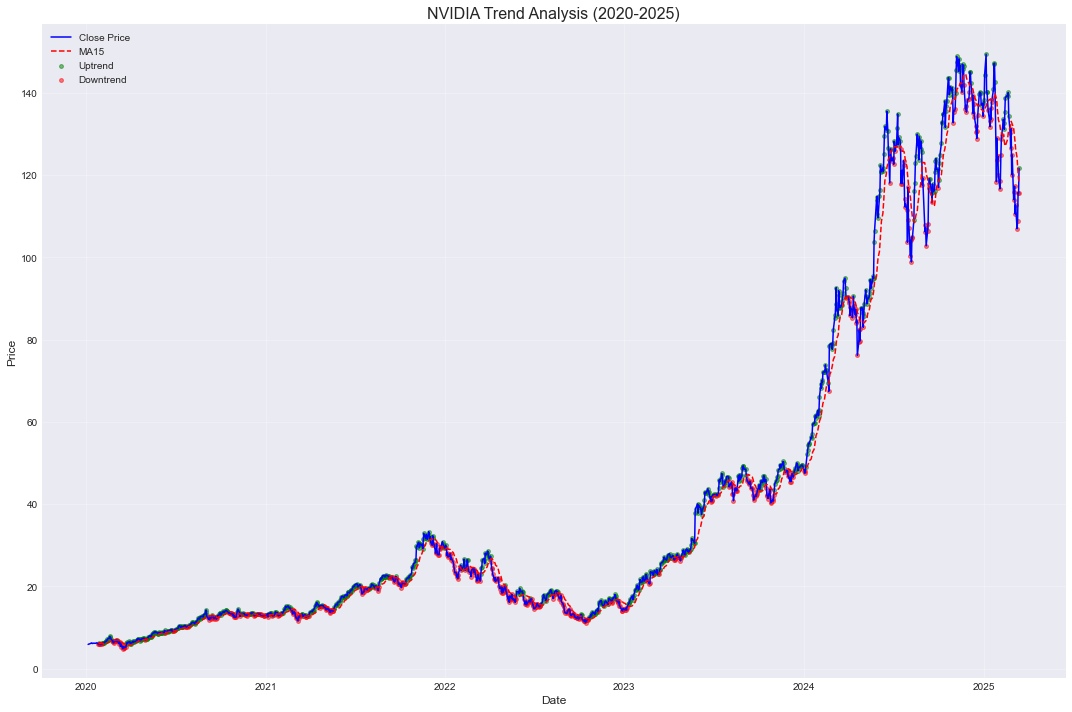

In [40]:
# Uses the MA15 to determine uptrend and downtrend sections.
# Extract data
nvda_df = tech_data['NVIDIA'].copy()
close_prices = nvda_df[('Close', 'NVDA')]
ma15_values = nvda_df[('MA15', '')]

aligned_rows = close_prices.notna() & ma15_values.notna() #Boolean table

# Aligned mask
uptrend_mask = (close_prices > ma15_values) & aligned_rows
downtrend_mask = (close_prices < ma15_values) & aligned_rows

# For data structures debugging
#print("\nClose column type:", type(close_prices))
#print("MA15 column type:", type(ma15_values))
#print("Uptrend:", uptrend_mask.iloc[1:30])
#print("Downtrend:", downtrend_mask.iloc[1:30])

uptrend = nvda_df.loc[uptrend_mask]
downtrend = nvda_df.loc[downtrend_mask]

# Plot results
plt.figure(figsize=(15, 10))

# Close price and MA15
plt.plot(nvda_df.index, close_prices, label='Close Price', color='blue')
plt.plot(nvda_df.index, ma15_values, label='MA15', color='red', linestyle='--')

# Uptrend and downtrend periods
plt.scatter(uptrend.index, uptrend[('Close', 'NVDA')], color='green', alpha=0.5, s=15, label='Uptrend')
plt.scatter(downtrend.index, downtrend[('Close', 'NVDA')], color='red', alpha=0.5, s=15, label='Downtrend')

plt.legend()
plt.title('NVIDIA Trend Analysis (2020-2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [41]:
# Restructured data function
def restructure_dataframes(data):
    restructured_data = {}
    
    for name, df in data.items():

        new_df = pd.DataFrame()
        
        # First pass - create technical indicator columns without ticker
        for col in df.columns:
            if isinstance(col, tuple):
                if col[0] in ['MA15', 'MACD26', 'K14', 'D3', 'RSI14', 'WR14']:
                    # Technical indicators get simple names
                    new_col_name = col[0]
                    new_df[new_col_name] = df[col]
                elif len(col) > 1 and col[1]:
                    # Price data gets ticker-specific names
                    new_col_name = f"{col[0]}_{col[1]}"
                    new_df[new_col_name] = df[col]
        
        # Create simple price columns for the current ticker only
        ticker_code = tickers[name]
        new_df['Close'] = new_df[f'Close_{ticker_code}']
        new_df['High'] = new_df[f'High_{ticker_code}']
        new_df['Low'] = new_df[f'Low_{ticker_code}']
        new_df['Open'] = new_df[f'Open_{ticker_code}']
        new_df['Volume'] = new_df[f'Volume_{ticker_code}']
        
        new_df.index = df.index
        restructured_data[name] = new_df
    
    return restructured_data

df_new = tech_data.copy()
new_tech_data = restructure_dataframes(df_new)

In [42]:
# Displays dataframe info for testing/debugging purposes.
for name in tickers.keys():
    print(f"Dataframe info for {name}:", new_tech_data[name].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2020-01-06 to 2025-03-14
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close_NVDA   1305 non-null   float64
 1   High_NVDA    1305 non-null   float64
 2   Low_NVDA     1305 non-null   float64
 3   Open_NVDA    1305 non-null   float64
 4   Volume_NVDA  1305 non-null   int64  
 5   MA15         1291 non-null   float64
 6   MACD26       1305 non-null   float64
 7   K14          1292 non-null   float64
 8   D3           1290 non-null   float64
 9   RSI14        1292 non-null   float64
 10  WR14         1292 non-null   float64
 11  Close        1305 non-null   float64
 12  High         1305 non-null   float64
 13  Low          1305 non-null   float64
 14  Open         1305 non-null   float64
 15  Volume       1305 non-null   int64  
dtypes: float64(14), int64(2)
memory usage: 173.3 KB
Dataframe info for NVIDIA: None
<class 'pandas.core.frame.DataFram

In [43]:
# This function prepares data for CEFLANN model training
def prepare_data(normalized_df, name, window_size=15):

    df = normalized_df.copy()
    
    # Original dataframe with restructured columns
    original_df = new_tech_data[name]
    
    # Adds the trend column (1 for uptrend, 0 for downtrend)
    df['trend'] = 0
    
    # Creates mask for valid data rows (both Close and MA15 are not NaN)
    valid_mask = original_df['Close'].notna() & original_df['MA15'].notna()
    
    ma_rising = original_df['MA15'].diff(5) > 0
    close_above_ma = original_df['Close'] > original_df['MA15']
    df.loc[valid_mask & ma_rising & close_above_ma, 'trend'] = 1
    
    # Downtrend: Close < MA15 and MA15 falling for 5 days
    ma_falling = original_df['MA15'].diff(5) < 0
    close_below_ma = original_df['Close'] < original_df['MA15']
    # trend=0 is already the default value
    
    # Generate trading signals in range 0-1 based on trend
    df['trading_signal'] = 0.5  # default for no clear trend
    
    for i in range(len(df) - 2):
        if i+3 > len(original_df):
            continue
            
        # Get prices for next 3 days
        prices = original_df['Close'].iloc[i:i+3].values
        
        if len(prices) < 3 or max(prices) <= min(prices):
            continue
            
        min_cp = min(prices)
        max_cp = max(prices)
        current_cp = original_df['Close'].iloc[i]
        
        # Calculate trading signal
        if df['trend'].iloc[i] == 1:  # Uptrend
            df.iloc[i, df.columns.get_loc('trading_signal')] = ((current_cp - min_cp) / (max_cp - min_cp)) * 0.5 + 0.5
        else:  # Downtrend
            df.iloc[i, df.columns.get_loc('trading_signal')] = ((current_cp - min_cp) / (max_cp - min_cp)) * 0.5
    
    # Drop NaN values
    df.dropna(inplace=True)
    
    # Features (X) and target (y)
    X = df[['MA15', 'MACD26', 'K14', 'D3', 'RSI14', 'WR14']].values
    y = df['trading_signal'].values
    
    return df, X, y

In [44]:
# Preparing the data for CEFLANN model for all indices
ceflann_data = {}
features = {}
targets = {}

for name in tickers.keys():
    
    ceflann_data[name], features[name], targets[name] = prepare_data(normalized_data[name], name)
    print(f"Prepared {len(features[name])} samples for CEFLANN model training for {name}")

Prepared 1290 samples for CEFLANN model training for NVIDIA
Prepared 1290 samples for CEFLANN model training for Taiwan Semiconductors
Prepared 1290 samples for CEFLANN model training for Invesco QQQ


In [45]:
# Display a sample of the prepared data for NVIDIA
#for name in tickers.keys():
print(ceflann_data['NVIDIA'].info())
print(ceflann_data['NVIDIA'].head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1290 entries, 2020-01-28 to 2025-03-14
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (MA15, )            1290 non-null   float64
 1   (MACD26, )          1290 non-null   float64
 2   (K14, )             1290 non-null   float64
 3   (D3, )              1290 non-null   float64
 4   (RSI14, )           1290 non-null   float64
 5   (WR14, )            1290 non-null   float64
 6   (Close, )           1290 non-null   float64
 7   (trend, )           1290 non-null   int64  
 8   (trading_signal, )  1290 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 100.8 KB
None
Price           MA15    MACD26       K14  ...     Close trend trading_signal
Ticker                                    ...                               
Date                                      ...                               
2020-01-28  0.002815  0.389955  0.576402  ...  6.

In [47]:
# Split the data into training, testing, and validation set weeks.
# Each set is one concurrent trading week long to match the simulation environment.
# Default split is 60:20:20, can be changed when called.
def split_data(data, train_ratio=0.6, test_ratio=0.2):
    """
    Arguments:
        data : DataFrame with DatetimeIndex containing features and target
        train_ratio : Proportion of weeks to use for training, default is 60%
        test_ratio: Proportion of weeks to use for testing, default 20%

        The remaining sets (1.0 - train_ratio - test_ratio) are used for evaluation.
        
    Returns:
        Dictionary containing training, testing, and evaluation data
    """
    # Drop all NaN values
    valid_data = data.dropna().copy()
    
    # Group by calendar week
    valid_data['calendar_week'] = valid_data.index.isocalendar().week
    valid_data['calendar_year'] = valid_data.index.isocalendar().year
    valid_data['week_id'] = valid_data['calendar_year'] * 100 + valid_data['calendar_week']
    
    # Get unique weeks sorted by date (oldest first)
    unique_weeks = sorted(valid_data['week_id'].unique())
    total_weeks = len(unique_weeks)

    # Mathematical check for parameter ratios.
    if (0.0 < test_ratio <= train_ratio < (test_ratio + train_ratio) < 1.0) != 1:
        print("Invalid ratios, using default settings...")
        train_ratio = 0.6
        test_ratio = 0.2
    
    # Calculate split point.
    n_train_weeks = int(total_weeks * train_ratio)
    n_test_weeks = int(total_weeks * test_ratio)
    
    # Separate sets
    train_week_ids = unique_weeks[:n_train_weeks]
    test_week_ids = unique_weeks[n_train_weeks:n_train_weeks+n_test_weeks]
    eval_week_ids = unique_weeks[n_train_weeks+n_test_weeks:]
    
    # Filter data
    train_data = valid_data[valid_data['week_id'].isin(train_week_ids)]
    test_data = valid_data[valid_data['week_id'].isin(test_week_ids)]
    eval_data = valid_data[valid_data['week_id'].isin(eval_week_ids)]
    
    # Create a list of individual test weeks
    test_weeks = []
    for week_id in test_week_ids:
        week_data = test_data[test_data['week_id'] == week_id].copy()
        test_weeks.append({
            'week_id': week_id,
            'data': week_data,
            'X': week_data[['MA15', 'MACD26', 'K14', 'D3', 'RSI14', 'WR14']].values,
            'y': week_data['trading_signal'].values,
            'dates': week_data.index,
            'close': week_data['Close'].values if 'Close' in week_data.columns else None,
        })
    
    eval_weeks = []
    for week_id in eval_week_ids:
        week_data = eval_data[eval_data['week_id'] == week_id].copy()
        eval_weeks.append({
            'week_id': week_id,
            'data': week_data,
            'X': week_data[['MA15', 'MACD26', 'K14', 'D3', 'RSI14', 'WR14']].values,
            'y': week_data['trading_signal'].values,
            'dates': week_data.index,
            'close': week_data['Close'].values if 'Close' in week_data.columns else None,
        })
    
    # Extract features and targets
    X_train = train_data[['MA15', 'MACD26', 'K14', 'D3', 'RSI14', 'WR14']].values
    y_train = train_data['trading_signal'].values
    
    # Store price data for training set
    train_price_data = train_data['Close'].values if 'Close' in train_data.columns else None
    
    return {
        'X_train': X_train,
        'y_train': y_train,
        'train_dates': train_data.index,
        'train_price_data': train_price_data,
        'test_weeks': test_weeks,
        'eval_weeks': eval_weeks,
        'n_train_weeks': len(train_week_ids),
        'n_test_weeks': len(test_week_ids),
        'n_eval_weeks': len(eval_week_ids)
    }

In [48]:
#test_dates = np.load('nvidia_test_weeks_info.npy', allow_pickle=True)
#test_dates

In [49]:
from pathlib import Path
#Ensure directories exist
output_dir = Path('data')
train_dir = Path(f'{output_dir}/npy/train')
test_dir = Path(f'{output_dir}/npy/test')
eval_dir = Path(f'{output_dir}/npy/eval')
output_dir.mkdir(parents=True, exist_ok=True)
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)
eval_dir.mkdir(parents=True, exist_ok=True)

# Export the dataframes to CSV
new_tech_data['NVIDIA'].to_csv(f'{output_dir}/nvidia_technical_data.csv')
normalized_data['NVIDIA'].to_csv(f'{output_dir}/nvidia_normalized_data.csv')
ceflann_data['NVIDIA'].to_csv(f'{output_dir}/nvidia_ceflann_data.csv')

# Split data
split_results = split_data(ceflann_data['NVIDIA'], train_ratio=0.6, test_ratio=0.2)
most_recent = split_results['test_weeks'][-1] if split_results['test_weeks'] else None

# Export training and testing sets to npy
np.save(f'{train_dir}/nvidia_X_train.npy', split_results['X_train'])
np.save(f'{train_dir}/nvidia_y_train.npy', split_results['y_train'])
np.save(f'{train_dir}/nvidia_train_dates.npy', split_results['train_dates'])
np.save(f'{train_dir}/nvidia_train_price_data.npy', split_results['train_price_data'])

# Export most recent week
if most_recent:
    np.save(f'{test_dir}/nvidia_X_test.npy', most_recent['X'])
    np.save(f'{test_dir}/nvidia_y_test.npy', most_recent['y'])
    np.save(f'{test_dir}/nvidia_test_dates.npy', most_recent['dates'])
    np.save(f'{test_dir}/nvidia_price_data.npy', most_recent['close'])

# Export all test weeks
test_weeks_info = []
for i, week in enumerate(split_results['test_weeks']):
    np.save(f'{test_dir}/nvidia_X_test_week_{i}.npy', week['X'])
    np.save(f'{test_dir}/nvidia_y_test_week_{i}.npy', week['y'])
    np.save(f'{test_dir}/nvidia_test_dates_week_{i}.npy', week['dates'])
    np.save(f'{test_dir}/nvidia_price_data_week_{i}.npy', week['close'])

    test_weeks_info.append({
        'week_id': week['week_id'],
        'start_date': week['dates'][0],
        'end_date': week['dates'][-1],
        'num_days': len(week['dates'])
    })

eval_weeks_info = []
for i, week in enumerate(split_results['eval_weeks']):
    np.save(f'{eval_dir}/nvidia_X_eval_week_{i}.npy', week['X'])
    np.save(f'{eval_dir}/nvidia_y_eval_week_{i}.npy', week['y'])
    np.save(f'{eval_dir}/nvidia_eval_dates_week_{i}.npy', week['dates'])
    np.save(f'{eval_dir}/nvidia_eval_price_data_week_{i}.npy', week['close'])
    
    # Add to evaluation weeks info
    eval_weeks_info.append({
        'week_id': week['week_id'],
        'start_date': week['dates'][0],
        'end_date': week['dates'][-1],
        'num_days': len(week['dates'])
    })

np.save(f'{output_dir}/npy/nvidia_test_weeks_info.npy', test_weeks_info)
np.save(f'{output_dir}/npy/nvidia_eval_weeks_info.npy', eval_weeks_info)

# Export meta information
with open(f'{output_dir}/nvidia_info.txt', 'w') as f:
    f.write(f"{new_tech_data['NVIDIA'].index[-1]},{new_tech_data['NVIDIA']['Close'].iloc[-1]}," +
            f"{len(most_recent['dates']) if most_recent else 0},{split_results['n_test_weeks']}," +
            f"{split_results['n_eval_weeks']}")

print(f"Split NVIDIA data into {split_results['n_train_weeks']} training weeks " +
      f"({len(split_results['X_train'])} samples), {split_results['n_test_weeks']} testing weeks, " +
      f"and {split_results['n_eval_weeks']} evaluation weeks")


Split NVIDIA data into 160 training weeks (772 samples), 53 testing weeks, and 55 evaluation weeks


In [50]:
# Summary of the dataset preparation
print("Dataset Summary for CEFLANN Model Implementation")
print("="*60)
print(f"Time Period: {start_date} to {end_date}")
print(f"Number of Trading Days: NVIDIA = {len(data['NVIDIA'])}")
print("\nTechnical Indicators Used:")
print("  - Simple Moving Average (MA15)")
print("  - Moving Average Convergence Divergence (MACD26)")
print("  - Stochastic Oscillator K14 and D3")
print("  - Relative Strength Index (RSI14)")
print("  - Larry Williams R% (WR14)")
print("\nData Preprocessing:")
print("  - Calculated technical indicators")
print("  - Normalized indicators to range [0,1]")
print("  - Generated trading signals in range [0,1]")
print("  - Split data into training, testing, and evaluation weeks")
print("\nThe dataset is now prepared to use with the CEFLANN model")

Dataset Summary for CEFLANN Model Implementation
Time Period: 2020-01-06 to 2025-03-15
Number of Trading Days: NVIDIA = 1305

Technical Indicators Used:
  - Simple Moving Average (MA15)
  - Moving Average Convergence Divergence (MACD26)
  - Stochastic Oscillator K14 and D3
  - Relative Strength Index (RSI14)
  - Larry Williams R% (WR14)

Data Preprocessing:
  - Calculated technical indicators
  - Normalized indicators to range [0,1]
  - Generated trading signals in range [0,1]
  - Split data into training, testing, and evaluation weeks

The dataset is now prepared to use with the CEFLANN model
